In [4]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import  tqdm

#%matplotlib inline

tqdm.pandas(tqdm)

import dask.dataframe as dd

from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display


/home/vandy/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from config_batch import * 

In [6]:
def call_ws(addr_data): #lg = "en,fr,nl"
    t = datetime.now()
    
    params = urllib.parse.urlencode({"street": addr_data[street_field],
                                     "housenumber": addr_data[housenbr_field],
                                     "city": addr_data[city_field],
                                     "postcode": addr_data[postcode_field],
                                     "country": addr_data[country_field],
                                    })
    url = "http://172.26.0.1:5000/search/?%s"%params
    
    
    try:
        with urllib.request.urlopen(url) as response:
            res = response.read()
            res = json.loads(res)
#             print(res)
            res["time"] = datetime.now() - t
            return res
    except Exception as e:
        return str(e)
    

In [7]:
def get_plots(addresses, column):
    fig, axes = plt.subplots(ncols=1, nrows = addresses[column].nunique(),  sharex=True, figsize=[6, 3*addresses[column].nunique()])

    addresses.hist(column="_time", by=column,ax=axes)

    return fig

In [8]:
addresses = get_addresses("address.csv.gz")

/home/vandy/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [83]:
display(addresses)


,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber
0,0200.065.765,Belgique,9070,Destelbergen,Panhuisstraat,1
1,0200.068.636,Belgique,9000,Gent,Stropstraat,1
2,0200.171.970,Belgique,9000,Gent,Brabantdam,101
3,0200.245.711,Belgique,9500,Geraardsbergen,Hoge Buizemont,247
4,0200.305.493,Belgique,9320,Aalst,Industrielaan,25
...,...,...,...,...,...,...
3112200,2.287.383.823,Belgique,2000.0,Antwerpen,Volkstraat,62-64
3112201,2.287.383.922,Belgique,2235.0,Hulshout,Ramselsesteenweg,52
3112202,2.287.384.021,Belgique,2910.0,Essen,Horendonk,316
3112203,2.287.384.120,Belgique,1060.0,Saint-Gilles,Rue de Danemark,30


In [95]:
addresses  =addresses.sample(10)

In [99]:
with_dask = False
if with_dask : 
    dd_addresses = dd.from_pandas(addresses, npartitions=4)

    dask_task = dd_addresses.apply(call_ws, meta=('x', 'str'), axis=1)

    with ProgressBar(): 
        addresses["json"] = dask_task.compute()
else: 
    
    addresses["json"] = addresses.progress_apply(call_ws, axis=1)

In [86]:
# Flask : 1:03
# gunicorn -w 1: 0:55
# gunicorn -w 2, npartition=2: 0:30
# gunicorn -w 2, npartition=4: 0:30
# gunicorn -w 4, npartition=4: 0:33

addresses

,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber,json
256721,0448.478.114,Belgique,8400,Oostende,Longchamplaan,29,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
352638,0466.085.493,Belgique,2950,Kapellen,Marcottedreef,17,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
2024228,2.101.805.502,Belgique,1080.0,Molenbeek-Saint-Jean,Rue de Birmingham,56,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
870179,0678.267.946,Belgique,8800,Roeselare,Meensesteenweg,466,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
593123,0566.988.259,Belgique,4960,Malmedy,Route de Falize,151,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
...,...,...,...,...,...,...,...
2698743,2.237.208.295,Belgique,9991,Maldegem,Veldekens,8,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
1423989,0853.547.639,Belgique,3001,Leuven,Naamsesteenweg,217,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
1688435,2.005.475.889,Belgique,1332,Rixensart,Drève du Val St-Pierre,1 6,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."
3033044,2.279.159.015,Belgique,2950,Kapellen,Kasteeldreef,3,"{'match': [{'SIM_street': 1.0, 'SIM_street_whi..."


In [87]:
addresses["status"]= addresses.json.apply(lambda d: "error" if "error" in d else "match" if "match" in d else "rejected")
addresses["time"]  = addresses.json.apply(lambda d: d["time"])

addresses["timing"]  = addresses.json.apply(lambda d: d["timing"] if "timing" in d else {})

addresses["method"]= addresses.json.apply(lambda d: d["match"][0]["method"] if len(d)>0 and "match" in d else "none")
addresses["street"]= addresses.json.apply(lambda d: d["match"][0]["addr_out_street"] if len(d)>0 and "match" in d else "")


display(addresses.drop("json", axis=1))

,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber,status,time,timing,method,street
256721,0448.478.114,Belgique,8400,Oostende,Longchamplaan,29,match,00:00:00.736235,{},orig,Longchamplaan
352638,0466.085.493,Belgique,2950,Kapellen,Marcottedreef,17,match,00:00:00.675106,{},orig,Marcottedreef
2024228,2.101.805.502,Belgique,1080.0,Molenbeek-Saint-Jean,Rue de Birmingham,56,match,00:00:01.173982,{},nonum,Rue de Birmingham - Birminghamstraat
870179,0678.267.946,Belgique,8800,Roeselare,Meensesteenweg,466,match,00:00:00.932640,{},orig,Meensesteenweg
593123,0566.988.259,Belgique,4960,Malmedy,Route de Falize,151,match,00:00:00.685588,{},orig,Route de Falize
...,...,...,...,...,...,...,...,...,...,...,...
2698743,2.237.208.295,Belgique,9991,Maldegem,Veldekens,8,match,00:00:00.968216,{},orig,Veldekens
1423989,0853.547.639,Belgique,3001,Leuven,Naamsesteenweg,217,match,00:00:00.855873,{},orig,Naamsesteenweg
1688435,2.005.475.889,Belgique,1332,Rixensart,Drève du Val St-Pierre,1 6,match,00:00:01.401952,{},orig,Drève du Val Saint-Pierre
3033044,2.279.159.015,Belgique,2950,Kapellen,Kasteeldreef,3,match,00:00:00.715824,{},orig,Kasteeldreef


In [88]:
addresses["timing"].apply(pd.Series)

""
256721
352638
2024228
870179
593123
...
2698743
1423989
1688435
3033044


In [89]:
display(addresses.status.value_counts())

match       491
rejected      9
Name: status, dtype: int64

In [90]:
addresses[addresses.status == "error"]

,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber,json,status,time,timing,method,street


In [80]:
# addresses[addresses.status == "error"].progress_apply(call_ws, axis=1)

2632339    {'match': [{'SIM_street': 1.0, 'SIM_street_whi...
2866222    {'match': [{'SIM_street': 1.0, 'SIM_street_whi...
50813      {'match': [{'SIM_street': 1.0, 'SIM_street_whi...
dtype: object

In [91]:
display(addresses.method.value_counts())

orig                                   377
nonum                                   54
regex[init]                             35
nostreet                                15
none                                     9
libpostal+regex[lpost]+photon            7
photon                                   2
libpostal+regex[lpost]+photon+nonum      1
Name: method, dtype: int64

In [63]:
addresses["_time"] = addresses.time.apply(lambda t: t.total_seconds())



In [30]:
print("Method : mean")

Method : mean


In [31]:
display(addresses.groupby("method")._time.mean())

method
libpostal+regex[lpost]           2.677368
libpostal+regex[lpost]+nonum     4.674206
libpostal+regex[lpost]+photon    5.003166
none                             5.497937
nonum                            1.895245
nostreet                         7.814610
orig                             1.278190
photon                           6.040788
regex[init]                      1.415722
Name: _time, dtype: float64

In [32]:
print("Method : std")

Method : std


In [33]:
display(addresses.groupby("method")._time.std())

method
libpostal+regex[lpost]           0.673513
libpostal+regex[lpost]+nonum          NaN
libpostal+regex[lpost]+photon    1.396333
none                             0.947713
nonum                            0.352042
nostreet                         2.791604
orig                             0.433419
photon                           1.985507
regex[init]                      0.227433
Name: _time, dtype: float64

In [34]:
print("Status : mean")

Status : mean


In [35]:
display(addresses.groupby("status")._time.mean())

status
error       5.304372
match       2.365954
rejected    5.525589
Name: _time, dtype: float64

In [36]:
print("Status : std")

Status : std


In [37]:
display(addresses.groupby("status")._time.std())

status
error            NaN
match       2.257369
rejected    1.020155
Name: _time, dtype: float64

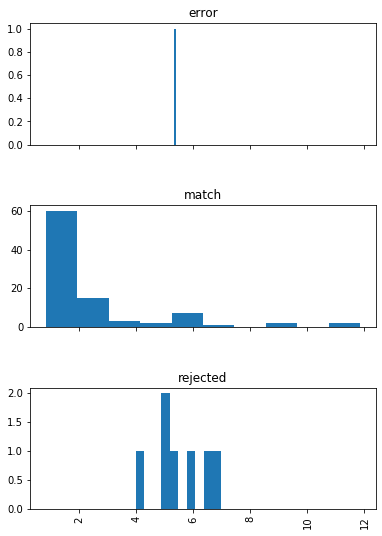

In [38]:
fig = get_plots(addresses, "status")

In [39]:
fig.savefig("time_per_status.png")

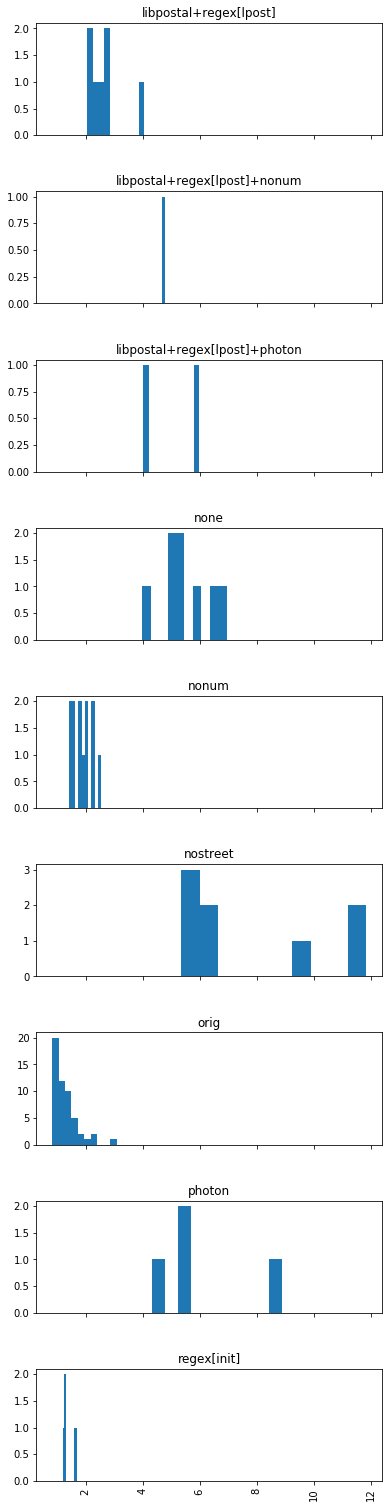

In [40]:
fig = get_plots(addresses, "method")

In [41]:
fig.savefig("time_per_method.png")

# Batch

In [ ]:
import urllib3

In [2]:
http = urllib3.PoolManager()

In [40]:
# file_data

In [35]:
# r.data

,addr_key,country,postcode,city,street,housenumber,osm_addr_in,place_id,lat,lon,...,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method,extra_house_nbr
0,0200.065.765,Belgique,9070,Destelbergen,Panhuisstraat,1,"Panhuisstraat, 1, 9070 Destelbergen, Belgique",2735074,51.053778,3.77391885009914,...,1.0,Panhuisstraat,Destelbergen,1,België / Belgique / Belgien,9070,Eenbeekeinde,None,orig,1
1,0200.068.636,Belgique,9000,Gent,Stropstraat,1,"Stropstraat, 1, 9000 Gent, Belgique",484031,51.0357569,3.7283446,...,1.0,Stropstraat,Gent,None,België / Belgique / Belgien,9000,Strop,None,orig,1
2,0200.171.970,Belgique,9000,Gent,Brabantdam,101,"Brabantdam, 101, 9000 Gent, Belgique",2320208,51.05002415,3.7312340901057,...,1.0,Brabantdam,Gent,101,België / Belgique / Belgien,9000,Zuid,None,orig,101
3,0200.245.711,Belgique,9500,Geraardsbergen,Hoge Buizemont,247,"Hoge Buizemont, 247, 9500 Geraardsbergen, Belg...",2313893,50.7544352,3.8765523,...,1.0,Hoge Buizemont,Geraardsbergen,None,België / Belgique / Belgien,9500,Grooten Buizemont,None,orig,247
4,0200.305.493,Belgique,9320,Aalst,Industrielaan,25,"Industrielaan, 25, 9320 Aalst, Belgique",1376249,50.9123652,4.0367197,...,1.0,Industrielaan,Aalst,None,België / Belgique / Belgien,9320,,None,orig,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0205.764.318,Belgique,1070,Anderlecht,Boulevard Sylvain Dupuis,251,"Boulevard Sylvain Dupuis, 251, 1070 Anderlecht...",1301074,50.83879245,4.28991437679886,...,1.0,Boulevard Sylvain Dupuis - Sylvain Dupuislaan,Anderlecht,251,België / Belgique / Belgien,1070,,None,orig,251
77,0205.774.810,Belgique,3000,Leuven,Brouwersstraat,6,"Brouwersstraat, 6, 3000 Leuven, Belgique",1458861,50.88288685,4.69610310174973,...,1.0,Brouwersstraat,Leuven,6,België / Belgique / Belgien,3000,Interleuven - Ridderbuurt,None,orig,6
78,0205.954.655,Belgique,1050,Ixelles,Rue de Naples,29,"Rue de Naples, 29, 1050 Ixelles, Belgique",892558,50.8377053,4.36576246959459,...,1.0,Rue de Naples - Napelsstraat,Ixelles - Elsene,29,België / Belgique / Belgien,1050,Matongé,None,orig,29
79,0205.970.788,Belgique,1800,Vilvoorde,Medialaan,28,"Medialaan, 28, 1800 Vilvoorde, Belgique",556431,50.91461645,4.40000205532192,...,1.0,Medialaan,Vilvoorde,26-28,België / Belgique / Belgien,1800,Business & Mediapark,None,orig,28


In [43]:
def call_ws_batch(addr_data, mode="geo"): #lg = "en,fr,nl"
    file_data = addr_data.rename(columns = {
        street_field : "street",
        housenbr_field: "housenumber",
        postcode_field: "postcode",
        city_field: "city",
        country_field: "country",
        addr_key_field : "addr_key"}).to_csv(index=False)
    
    r = http.request(
    'POST',
    'http://127.0.0.1:5000/batch',
    fields= { 
        'media': ('addresses.csv', file_data),
        'mode': mode
    })
    
    return pd.DataFrame(json.loads(r.data.decode('utf-8')))
    

In [55]:
res = call_ws_batch(addresses.iloc[0:50])

In [57]:
res.lon.mean()

4.556351480945

NameError: name 'pd' is not defined